In [ ]:
#Class Feedback

# Don't go back before 1974 due to change to gold standard - causes for recessions may have changed
# Deeper exploration of housing predictors
# Asymptotic Series - Ask remus about what to do here

In [1]:

"""NEXT STEPS:

DATA:
1. STORE HISTORICAL DATA
    a. Get recession dates loaded
    b. Convert all series to daily (generic function)
    https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
    c. Adjust for inflation where necessary (generic function)
    d. Feature Engineering (trended attributes, etc..)
    (Based on NBER dates - I would define a recession based on SP500 pct drop from prior peak (12mo))
    e. Load to db

MODEL:
2. Employ Prophet for TimeSeries modelling
    a. 1 Model with wide prediction range (3mo)
    b. 1 Model with short perdiction range (1mo)
3. Re-run 'best' models every day and check against prior scores

DATA Part2:
4. DATA UPDATE PROCESS
    a. daily check for each dataset
    b. repeat steps 1b/1c
    c. email alerts if data update fails

ALERTS:
5. Email Alerts if model scores change within a tolerance

"""

"""
Goal: To build a basic economic model for the US Economy in order to roughly predict 
a downturn. Prob(downturn in 3 months). 

Steps: 
Gather quality data in time-series
Train/Test model
Automate from the outset so model can ingest new data and re-run daily
Alert if target probability exceeds alert threshold

Data sources:
FRED Data (st louis federal reserve) - https://fred.stlouisfed.org/
FRED API - https://github.com/mortada/fredapi
List of other datasets: https://www.aeaweb.org/rfe/showCat.php?cat_id=3

Indicators we care about:
Private Debt, Household Debt vs. GDP
Personal Income
Unemployment Rate
Interest rates
Monetary Supply
CPI
GDP
Public Debt
Credit in the economy
VIX index
Total US Population
YieldCurve/Treasury spreads (2-10yr bonds)
YieldCurve/Treasury spreads (3mo-10yr bonds)
S&P500 - Measure of total us stock market prices(target)
Charge Off Rates - FED published for top banks, other source as well
"""

import json, sqlite3, os, sys, datetime, urllib
import pandas as pd
import numpy as np
from fredapikey import apikey
from fredapi import Fred
from functools import reduce
from zipfile import ZipFile
import seaborn as sns
sns.set_context("paper")
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

verbose = 1
dir_path = '.'
dbpathname = '/stego.db'
fred = Fred(api_key=apikey)

#Create or Connect to existing Sqlite DB
if not os.path.isfile(str(dir_path)+dbpathname):
    con=dbprocess(path=dir_path)

con = sqlite3.connect(str(dir_path)+dbpathname) #connect to existing sqlite db
cur = con.cursor()

In [2]:
def echo(msg, verbosity=verbose):
    if verbosity == 1:
        print(msg) 
    else:
        return None

def dbprocess(path):
    try:
        echo(msg='Loading DB...',verbosity=1)
        con = sqlite3.connect(str(path)+dbpathname) #connect to existing or create new if does not exist
        cur = con.cursor()
        cur.execute('CREATE TABLE daily_trades([index] bigint, asset varchar(5), exchange varchar(100), time_start datetime, time_end datetime, trades_count bigint, volume_traded decimal(20,10), price_open decimal(20,10), price_high decimal(20,10), price_low decimal(20,10), price_close decimal(20,10))')
        #cur.execute('CREATE INDEX IDX_time ON daily_trades (time_start, time_end)')
        con.commit()
    except sqlite3.Error as e:
        echo(msg="Error {}:".format(e.args[0]),verbosity=1)
        os._exit(1)
    finally:
        if con:
            con.close()

def dailyresample(data, seriesname):
    #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html
    #https://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    if isinstance(data, pd.Series):
        s = data.resample('D').pad()
        df = s.to_frame(name=seriesname)
        df.index.name='date'
        return df
    else:
        print('not a pandas series - need code')
        raise

In [3]:
#Historical Data Load
#   Recession Dates
dtype = {'c':str,'d':str,'e':int,'f':int,'g':int,'h':int,'i':int,'j':int}
rcs_df = pd.read_excel(io=dir_path+"/required/NBER chronology.xlsx",
                    sheet_name=0,
                    header=2,
                    usecols="C:J",
                    dtype=dtype,
                    nrows=34)
rcs_df['Peak month'] = rcs_df['Peak month'].apply(lambda x: '01 {}'.format(x))
rcs_df['Trough month'] = rcs_df['Trough month'].apply(lambda x: '01 {}'.format(x))
df_dates = pd.to_datetime(rcs_df[['Peak month','Trough month']].stack(),errors='coerce',format='%d %B %Y').unstack()
rcs_df = pd.merge(rcs_df, df_dates, left_index=True, right_index=True)[['Peak month_y','Trough month_y','Peak month number','Trough month number','Duration, peak to trough','Duration, trough to peak','Duration, trough to trough','Duration, peak to peak']]
rcs_df.rename(index=str, columns={'Peak month_y': 'peak','Trough month_y': 'trough'}, inplace=True)

#   S&P500 History (Macrotrends data from Dec-1927)
#   https://macrotrends.dpdcart.com/product/126227
sp_df = pd.read_csv(filepath_or_buffer=dir_path+"/required/Macrotrends-s-p-500-index-daily.csv",
                    delimiter=',',
                    skiprows=8,
                    header=0,
                    usecols=[0,1],
                    dtype=dtype)
sp_df.set_index(pd.DatetimeIndex(sp_df['Date']),inplace=True)
sp_df.drop(columns=['Date'],inplace=True)
sp_df.rename(columns={'Closing Value': 'SP500'},inplace=True)
sp_df = dailyresample(data=sp_df['SP500'],seriesname='SP500')
#fill missing values (mostly weekends and holidays)
sp_df.interpolate(method='linear',limit_direction='forward',limit_area='inside',inplace=True)


#   S&P500 History (Shiller simulated monthly data from Jan-1871)
try:
    shiller_df = pd.read_excel(io=dir_path+"/required/ie_data.xls",
                            sheet_name="Data",
                            header=7,
                            usecols="A:B,K",
                            nrows=1773)
except:
    #   http://www.econ.yale.edu/~shiller/data/ie_data.xls
    urllib.request.urlretrieve('http://www.econ.yale.edu/~shiller/data/ie_data.xls','./required/ie_data.xls')
    shiller_df = pd.read_excel(io=dir_path+"/required/ie_data.xls",
                                sheet_name="Data",
                                header=7,
                                usecols="A:B,K",
                                nrows=1773)

shiller_df['Date'] = shiller_df['Date'].apply(lambda x: '{}0'.format(x)[:7]+'.01')
shiller_df.set_index(pd.DatetimeIndex(shiller_df['Date']),inplace=True)
shiller_df.drop(columns=['Date'],inplace=True)
shiller_df.rename(columns={'Closing Value': 'SP500'},inplace=True)
shiller_sp500 = dailyresample(data=shiller_df['P'],seriesname='SP500')
shiller_sp500 = shiller_sp500.loc[:'1927-12-29'] #remove dates that overlap with our other datasets

#   S&P500 History from FRED goes back to 2008
SP500 = fred.get_series('SP500')
SP500 = dailyresample(data=SP500,seriesname='SP500')
#fill missing values (mostly weekends and holidays)
SP500.interpolate(method='linear',limit_direction='forward',limit_area='inside',inplace=True)
SP500 = SP500.loc['2018-10-12':]

SP500=pd.concat([shiller_sp500,sp_df,SP500]) #union all our normalized SP500 data. 



#CAPE index by Shiller
shiller_cape = dailyresample(data=shiller_df['CAPE'],seriesname='CAPE')
shiller_cape = shiller_cape.loc['1881-01-01':] #remove NaN dates

VIXCLS = fred.get_series('VIXCLS') #CBOE Volatility Index (VIX), Daily
VIXCLS = dailyresample(data=VIXCLS,seriesname='VIXCLS')

UMCSENT = fred.get_series('UMCSENT') # University of Michigan: Consumer Sentiment, Monthly
UMCSENT = dailyresample(data=UMCSENT,seriesname='UMCSENT')

STLFSI = fred.get_series('STLFSI') # St. Louis Fed Financial Stress Index, Weekly
STLFSI = dailyresample(data=STLFSI,seriesname='STLFSI')

#Need to adjust for inflation to get Real
NPPTTL = fred.get_series('NPPTTL') # Total Nonfarm Private Payroll Employment, Monthly
NPPTTL = dailyresample(data=NPPTTL,seriesname='NPPTTL')

PERMIT = fred.get_series('PERMIT') # New Private Housing Units Authorized by Building Permits, Monthly
PERMIT = dailyresample(data=PERMIT,seriesname='PERMIT')

DGORDER = fred.get_series('DGORDER') # Manufacturers' New Orders: Durable Goods, Seasonally Adjusted, Monthly
DGORDER = dailyresample(data=DGORDER,seriesname='DGORDER')

JTSQUR = fred.get_series('JTSQUR') #Job Openings and Labor Turnover (JOLTS) - Quits: NonFarm, Seasonally Adjusted, Monthly
JTSQUR = dailyresample(data=JTSQUR,seriesname='JTSQUR')


"""
The first indicator is the unemployment gap, which is the difference between the unemployment rate and the natural rate of unemployment (formerly called NAIRU, for the non-accelerating inflation rate of unemployment). 
A strong labor market prompts the Fed to tighten because an unemployment rate well below the natural rate is unsustainable by definition, and can lead to a spike in wage and price inflation. 
Looking at the current cycle, the labor market is in the early stages of overheating. We see unemployment heading to 3.5 percent, which would be consistent with the pre-recession behavior of the unemployment gap in past cycles.
"""
#Unemployment Gap  = Unemployment Rate – Natural Rate of Unemployment
NROU = fred.get_series('NROU') # Natural Rate of Unemployment (Long-Term), Quarterly
NROU = dailyresample(data=NROU,seriesname='NROU')

NROUST = fred.get_series('NROUST') # Natural Rate of Unemployment (Short-Term), Quarterly
NROUST = dailyresample(data=NROUST,seriesname='NROUST')

UNRATE = fred.get_series('UNRATE') # Civilian Unemployment Rate
UNRATE = dailyresample(data=UNRATE,seriesname='UNRATE')

UNRATE=pd.merge(UNRATE,NROU,how='left',on='date')
UNRATE=pd.merge(UNRATE,NROUST,how='left',on='date')
UNRATE['UNGAP']=UNRATE['UNRATE']-UNRATE['NROU']
UNRATE['UNGAPST']=UNRATE['UNRATE']-UNRATE['NROUST']
UNRATE[['UNGAP','UNGAPST']]=UNRATE[['UNGAP','UNGAPST']].fillna(0)

"""
One of the most reliable and consistent predictors of recession has been the Treasury yield curve. Recessions are always preceded by a flat or inverted yield curve, usually occurring about 12 months before the downturn begins. 
This occurs with T-bill yields rising as Fed policy becomes restrictive while 10-year yields rise at a slower pace. Looking at the current cycle, we expect that steady increases in the fed funds rate will continue to flatten the yield curve over the next 12–18 months.
Three Month–10 Year Treasury Yield Curve (bps)
"""
T10Y2Y = fred.get_series('T10Y2Y') # 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity, Daily
T10Y2Y = dailyresample(data=T10Y2Y,seriesname='T10Y2Y')

T10Y3M = fred.get_series('T10Y3M') # 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity, Daily
T10Y3M = dailyresample(data=T10Y3M,seriesname='T10Y3M')

"""
Other indicators of the real economy, including aggregate weekly hours, decline in the months preceding a recession as employers begin to reduce headcount and cut the length of the workweek. 
Looking at the current cycle, aggregate weekly hours growth has been steady, albeit at weaker than average levels, reflecting slower labor force growth as baby boomers retire. 
We expect growth in hours worked to hold up over the coming year before slowing more markedly in 2019.
Aggregate Weekly Hours Worked, Year-over-Year % Change
"""
HOHWMN02USM065S = fred.get_series('HOHWMN02USM065S') # Weekly Hours Worked: Manufacturing for the United States, Monthly
HOHWMN02USM065S = dailyresample(data=HOHWMN02USM065S,seriesname='HOHWMN02USM065S')


"""
Real retail sales growth weakens significantly before a recession begins, with the inflection point typically occurring about 12 months before the start of the recession. 
Consumers cut back on spending as they start to feel the impact of slowing real income growth. This shows up most noticeably in retail sales, which are made up of a higher share of discretionary purchases than other measures of consumption. 
Looking at the current cycle, real retail sales growth has been steady at around 2 percent. This is weaker than the historical average, but is consistent with slower-trend gross domestic product (GDP) growth in this cycle.
"""
#Need to adjust for inflation to get Real
RETAILSMSA = fred.get_series('RETAILSMSA') # Retailers Sales, Seasonally Adjusted, Monthly
RETAILSMSA = dailyresample(data=RETAILSMSA,seriesname='RETAILSMSA')

#CPI Index for INFLATION ADJUSTMENT (goes back to 1913)
CPIAUCNS = fred.get_series('CPIAUCNS') # Consumer Price Index for All Urban Consumers: All Items
CPIAUCNS = dailyresample(data=CPIAUCNS,seriesname='CPIAUCNS')
CPIAUCNS['CPIMultiplier'] = CPIAUCNS['CPIAUCNS'].iloc[-1] / CPIAUCNS['CPIAUCNS'] #index to today's prices

#Availability Notes:
#CAPE from 1881
#UNGAP from 1948
#UMCSENT from 1953
#PERMIT from 1960
#HOHWMN02USM065S from 1960
#econuncert_h1, h3, h12 and finuncert_h1, h3, h12 from 1960
#T10Y2Y from 1976
#T10Y3M from 1982
#VIXCLS from 1990
#RETAILSMSA_REAL from 1992
#DGORDER, STLFSI  from 1993
#JTSQUR from 2000
#NPPTTL_REAL from 2002


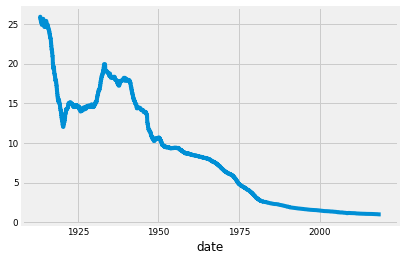

In [4]:
#The further back you go, the more you must inflation adjust. Its not a stright line through history b/c the level of inflation has varied.
CPIAUCNS.CPIMultiplier.plot()

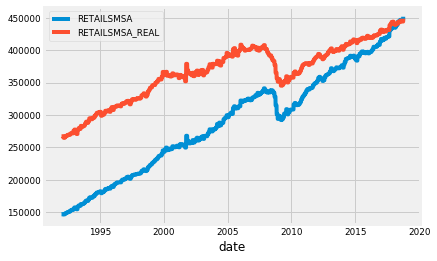

In [5]:
#Inflation Adjustments
RETAILSMSA=pd.merge(RETAILSMSA,CPIAUCNS,how='left',on='date')
RETAILSMSA['RETAILSMSA_REAL']=RETAILSMSA['RETAILSMSA']*RETAILSMSA['CPIMultiplier']
RETAILSMSA[['RETAILSMSA','RETAILSMSA_REAL']].plot()

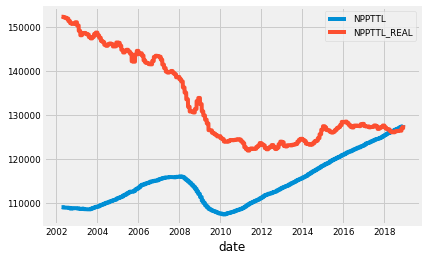

In [6]:
NPPTTL=pd.merge(NPPTTL,CPIAUCNS,how='left',on='date')
NPPTTL['NPPTTL_REAL']=NPPTTL['NPPTTL']*NPPTTL['CPIMultiplier']
NPPTTL[['NPPTTL','NPPTTL_REAL']].plot()

In [7]:
#Pull Economic Uncertainty Index
#https://www.sydneyludvigson.com/data-and-appendixes/
#https://www.sydneyludvigson.com/s/MacroFinanceUncertainty_2018AUG_update.zip
try:
    zip_file = ZipFile('./required/MacroFinanceUncertainty_2018AUG_update.zip')
except:
    urllib.request.urlretrieve('https://www.sydneyludvigson.com/s/MacroFinanceUncertainty_2018AUG_update.zip','./required/MacroFinanceUncertainty_2018AUG_update.zip')

econuncert_df = pd.read_csv(filepath_or_buffer=zip_file.open('MacroUncertaintyToCirculate.csv'),header=0)
econuncert_df.set_index(pd.DatetimeIndex(econuncert_df['Date']),inplace=True)
econuncert_df.drop(columns=['Date'],inplace=True)
econuncert_1_df = dailyresample(data=econuncert_df['h=1'],seriesname='econuncert_h1') #h1 = 1 month ahead
econuncert_3_df = dailyresample(data=econuncert_df['h=3'],seriesname='econuncert_h3') #h3 = 3 months ahead
econuncert_12_df = dailyresample(data=econuncert_df['h=12'],seriesname='econuncert_h12') #h12 = 12 months ahead

finuncert_df = pd.read_csv(filepath_or_buffer=zip_file.open('FinancialUncertaintyToCirculate.csv'),header=0)
finuncert_df.set_index(pd.DatetimeIndex(finuncert_df['Date']),inplace=True)
finuncert_df.drop(columns=['Date'],inplace=True)
finuncert_1_df = dailyresample(data=finuncert_df['h=1'],seriesname='finuncert_h1')
finuncert_3_df = dailyresample(data=finuncert_df['h=3'],seriesname='finuncert_h3')
finuncert_12_df = dailyresample(data=finuncert_df['h=12'],seriesname='finuncert_h12')

#finuncert_1_df.head()

In [8]:
#Scrape LEI data from web (auto or manual)
#https://www.conference-board.org/data/bciarchive.cfm?cid=1

In [9]:
#Construct main dataframe indexed on our dates
start_date=datetime.date(1871,1,1)
end_date=datetime.datetime.today().date()
days=(end_date-start_date).days
index = pd.date_range(start=start_date, end=end_date)
s = pd.Series(range(days+1), index=index)
main_df = s.to_frame(name='daynum')

#Merge all dataframes into 1 dataset
#https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns
dfs = [main_df,SP500,VIXCLS,UMCSENT,STLFSI,NPPTTL,PERMIT,DGORDER,JTSQUR,T10Y2Y,T10Y3M,HOHWMN02USM065S,RETAILSMSA,UNRATE[['UNGAP']],shiller_cape,econuncert_1_df,econuncert_3_df,econuncert_12_df,finuncert_1_df,finuncert_3_df,finuncert_12_df]
main_df = reduce(lambda left,right: pd.merge(left,right,how='outer',left_index=True,right_index=True), dfs)
main_df.drop(inplace=True,columns=['NPPTTL','CPIAUCNS_x','CPIMultiplier_x','RETAILSMSA','CPIAUCNS_y','CPIMultiplier_y'])

#We wont extrapolate any SP500 data without a proper model, so drop any dates that are stil NULL
main_df = main_df[~main_df.SP500.isnull().values]

#double check
assert(len(main_df[main_df.SP500.isnull().values])==0)

#interpolate missing intermediate dates + extrapolate last data to present day for any of the predictors
main_df.interpolate(method='linear',limit_direction='forward',inplace=True)

In [10]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54075 entries, 1871-01-01 to 2019-01-18
Data columns (total 21 columns):
daynum             54075 non-null int64
SP500              54075 non-null float64
VIXCLS             10610 non-null float64
UMCSENT            24186 non-null float64
STLFSI             9151 non-null float64
NPPTTL_REAL        6138 non-null float64
PERMIT             21569 non-null float64
DGORDER            9850 non-null float64
JTSQUR             6624 non-null float64
T10Y2Y             15573 non-null float64
T10Y3M             13530 non-null float64
HOHWMN02USM065S    21569 non-null float64
RETAILSMSA_REAL    9881 non-null float64
UNGAP              25952 non-null float64
CAPE               50422 non-null float64
econuncert_h1      21387 non-null float64
econuncert_h3      21387 non-null float64
econuncert_h12     21387 non-null float64
finuncert_h1       21387 non-null float64
finuncert_h3       21387 non-null float64
finuncert_h12      21387 non-null float64

In [11]:
display(main_df.head())
display(main_df.tail())

,daynum,SP500,VIXCLS,UMCSENT,STLFSI,NPPTTL_REAL,PERMIT,DGORDER,JTSQUR,T10Y2Y,T10Y3M,HOHWMN02USM065S,RETAILSMSA_REAL,UNGAP,CAPE,econuncert_h1,econuncert_h3,econuncert_h12,finuncert_h1,finuncert_h3,finuncert_h12
1871-01-01,0,4.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-01-02,1,4.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-01-03,2,4.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-01-04,3,4.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-01-05,4,4.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,daynum,SP500,VIXCLS,UMCSENT,STLFSI,NPPTTL_REAL,PERMIT,DGORDER,JTSQUR,T10Y2Y,T10Y3M,HOHWMN02USM065S,RETAILSMSA_REAL,UNGAP,CAPE,econuncert_h1,econuncert_h3,econuncert_h12,finuncert_h1,finuncert_h3,finuncert_h12
2019-01-14,54069,2582.61,19.07,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.18,0.26,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323
2019-01-15,54070,2610.30,18.60,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.19,0.27,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323
2019-01-16,54071,2616.10,19.04,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.18,0.30,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323
2019-01-17,54072,2635.96,18.06,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.19,0.33,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323
2019-01-18,54073,2670.71,18.06,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.19,0.33,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323


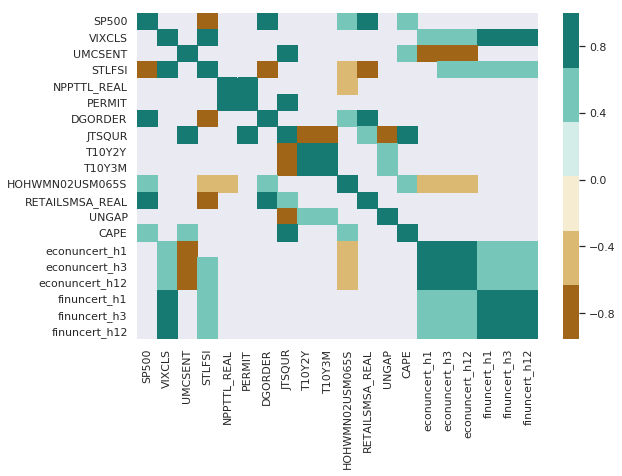

In [12]:
corr=main_df.drop(columns='daynum').corr()
corr[abs(corr)>=.5] #Where correlation >50% or <-50%
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(corr[abs(corr)>=.5],cmap=sns.color_palette('BrBG'))
#There are some high correlations between features but there is enough uncertainty about predictive power I am choosing to hang on to all features for now

In [13]:
#sns.pairplot(main_df.drop(columns='daynum'))

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


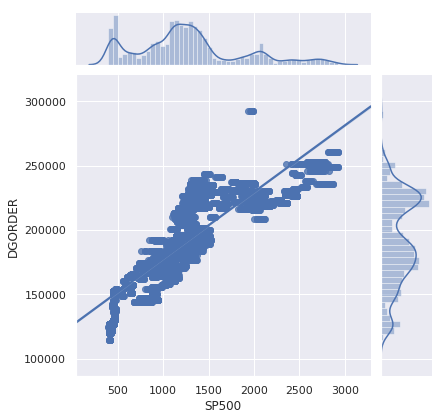

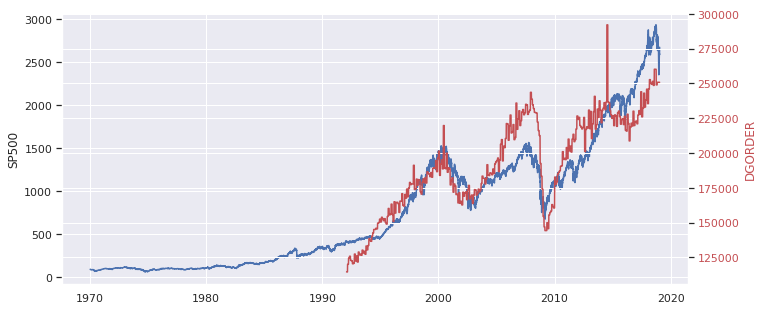

In [14]:
sns.jointplot(main_df.SP500,main_df.DGORDER,kind='reg') # Manufacturers' New Orders: Durable Goods, Seasonally Adjusted, Monthly

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].SP500)
ax1.set_ylabel('SP500')
ax2 = ax1.twinx()
ax2.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].DGORDER, 'r-')
ax2.set_ylabel('DGORDER', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

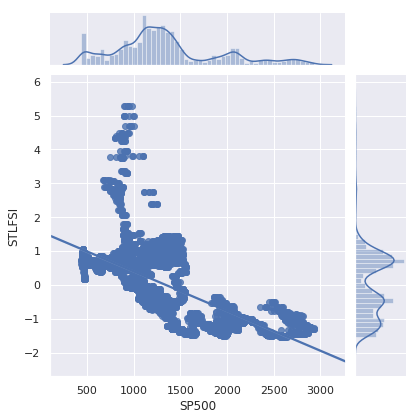

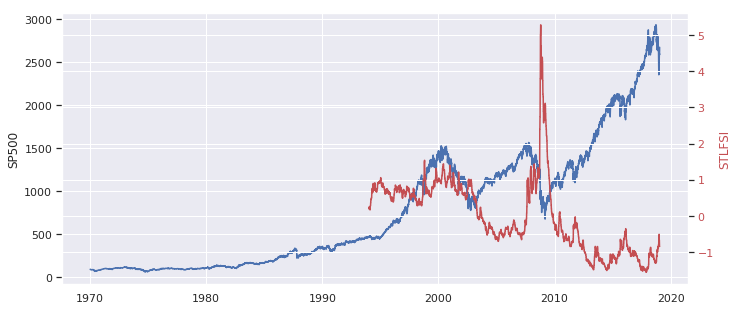

In [15]:
sns.jointplot(main_df.SP500,main_df.STLFSI,kind='reg') # St. Louis Fed Financial Stress Index, Weekly

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].SP500)
ax1.set_ylabel('SP500')
ax2 = ax1.twinx()
ax2.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].STLFSI, 'r-')
ax2.set_ylabel('STLFSI', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

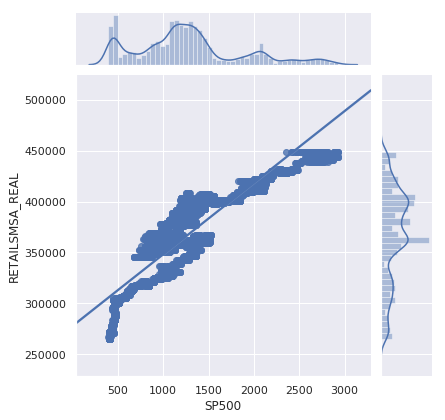

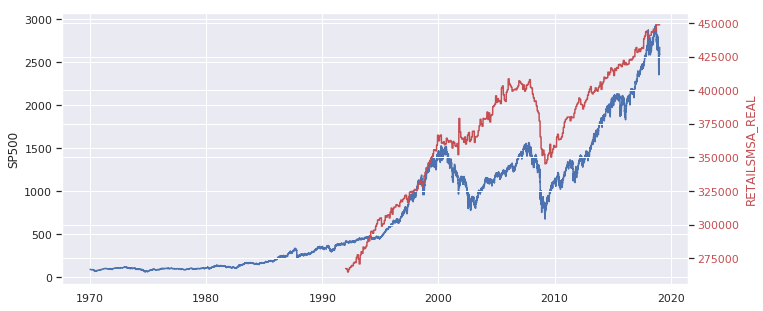

In [16]:
sns.jointplot(main_df.SP500,main_df.RETAILSMSA_REAL,kind='reg') #Retail Sales, Seasonally Adjusted, Inflation Adjusted

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].SP500)
ax1.set_ylabel('SP500')
ax2 = ax1.twinx()
ax2.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].RETAILSMSA_REAL, 'r-')
ax2.set_ylabel('RETAILSMSA_REAL', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

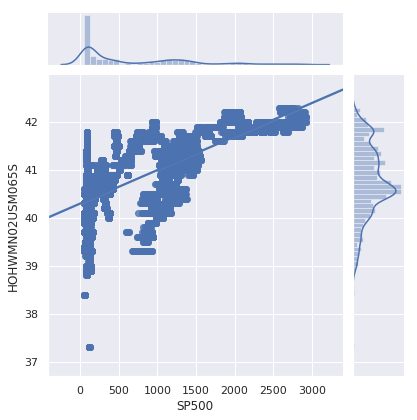

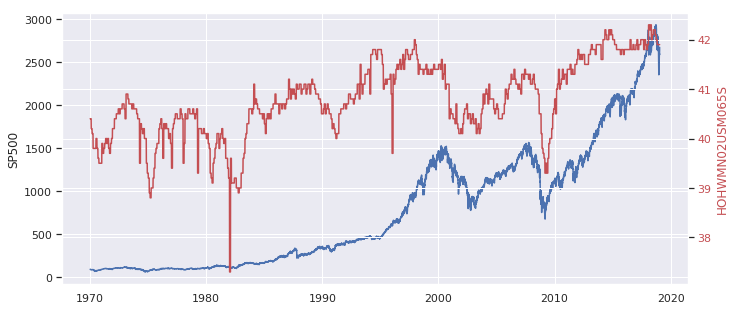

In [17]:
sns.jointplot(main_df.SP500,main_df.HOHWMN02USM065S,kind='reg') # Weekly Hours Worked: Manufacturing for the United States, Monthly

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].SP500)
ax1.set_ylabel('SP500')
ax2 = ax1.twinx()
ax2.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].HOHWMN02USM065S, 'r-')
ax2.set_ylabel('HOHWMN02USM065S', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

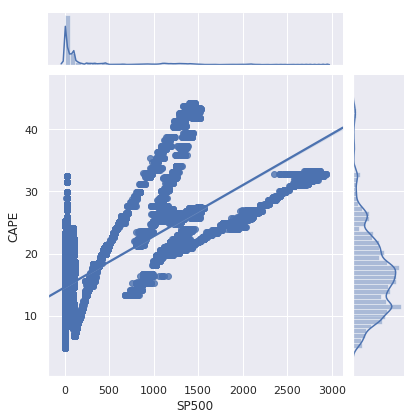

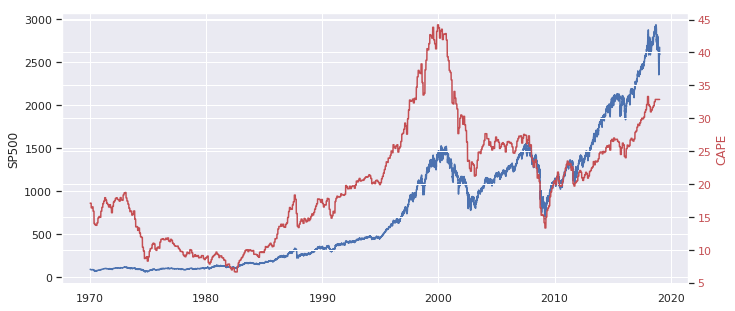

In [18]:
sns.jointplot(main_df.SP500,main_df.CAPE,kind='reg') #Cyclically Adjusted Price-Earnings Ratios (shiller)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].SP500)
ax1.set_ylabel('SP500')
ax2 = ax1.twinx()
ax2.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].CAPE, 'r-')
ax2.set_ylabel('CAPE', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

In [88]:
#Look at our official recession dates
display(rcs_df[:])

,peak,trough,Peak month number,Trough month number,"Duration, peak to trough","Duration, trough to peak","Duration, trough to trough","Duration, peak to peak"
0,NaT,1854-12-01,NaN,660,NaN,NaN,NaN,NaN
1,1857-06-01,1858-12-01,690.0,708,18.0,30.0,48.0,NaN
2,1860-10-01,1861-06-01,730.0,738,8.0,22.0,30.0,40.0
3,1865-04-01,1867-12-01,784.0,816,32.0,46.0,78.0,54.0
4,1869-06-01,1870-12-01,834.0,852,18.0,18.0,36.0,50.0
5,1873-10-01,1879-03-01,886.0,951,65.0,34.0,99.0,52.0
6,1882-03-01,1885-05-01,987.0,1025,38.0,36.0,74.0,101.0
7,1887-03-01,1888-04-01,1047.0,1060,13.0,22.0,35.0,60.0
8,1890-07-01,1891-05-01,1087.0,1097,10.0,27.0,37.0,40.0
9,1893-01-01,1894-06-01,1117.0,1134,17.0,20.0,37.0,30.0


(680300.35, 739780.65, -0.05, 1.05)

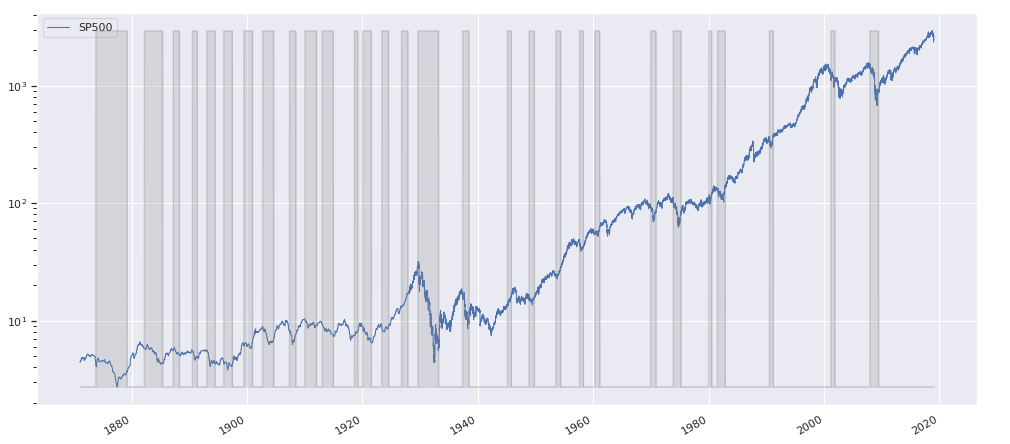

In [52]:
#Show SP500 history with recessions visible
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
main_df['1854-12-01':].plot(kind='line',y=['SP500'],ax=ax0,linewidth=1.0,figsize=(15,8),logy=True)
main_df['recession'].plot(kind='area', secondary_y=True, ax=ax1, alpha=.2, color='grey')
plt.axis('off')

In [90]:
#Map our recession dates onto our main dataframe

#Set our recession dates
main_df['next_recession_date'] = np.NaN
main_df['recession'] = 0
main_df['recession_start'] = 0
main_df['recession_end'] = 0
main_df['SP500_last_peak'] = 0
main_df['SP500_last_trough'] = 0
for index, row in rcs_df.iterrows():
    main_df.loc[(main_df.index>=row.peak) & (main_df.index<=row.trough), 'recession'] = 1
    main_df.loc[(main_df.index==row.peak), 'recession_start'] = 1
    main_df.loc[(main_df.index==row.trough), 'recession_end'] = 1
    try:
        main_df.loc[(main_df.index>=row.peak) & (main_df.index<=rcs_df.iloc[int(index)+1].peak), 'SP500_last_peak'] =  main_df.loc[main_df.index==row.peak].SP500.values #peak to peak
        main_df.loc[(main_df.index>=row.trough) & (main_df.index<=rcs_df.iloc[int(index)+1].trough), 'SP500_last_trough'] =  main_df.loc[main_df.index==row.trough].SP500.values  #trough to trough
        main_df.loc[(main_df.index>=row.peak) & (main_df.index<rcs_df.iloc[int(index)+1].peak), 'next_recession_date'] = rcs_df.iloc[int(index)+1].peak
    except:
        pass

#Calc 'months before recession' feature (could be our target)
main_df['days_to_rec'] = (pd.to_datetime(main_df.next_recession_date) - main_df.index)/np.timedelta64(1, 'D') #convert to days
main_df['months_to_rec'] = (pd.to_datetime(main_df.next_recession_date) - main_df.index)/np.timedelta64(1, 'M') #convert to months
main_df['months_to_rec_round'] = np.round((pd.to_datetime(main_df.next_recession_date) - main_df.index)/np.timedelta64(1, 'M')) #convert to months    
main_df['3m_to_rec'] = np.where(main_df.months_to_rec_round.isin([0,1,2,3]),1,0)
main_df['6m_to_rec'] = np.where(main_df.months_to_rec_round.isin([0,1,2,3,4,5,6]),1,0)
    
#Calc SP500 chg vs. prior peak/trough
main_df['SP500_chg_from_peak'] = (main_df.SP500 - main_df.SP500_last_peak)*1.0/main_df.SP500_last_peak*1.0
main_df['SP500_chg_from_trough'] = (main_df.SP500 - main_df.SP500_last_trough)*1.0/main_df.SP500_last_trough*1.0

In [92]:
#Trend the S&P by 6mo, 12mo, 24mo. Compare current to prior highs from these periods. 

#display(main_df[main_df.recession_start==1])
#display(main_df[main_df.recession_end==1])

display(main_df['2001-02-27':'2001-03-05'])

,daynum,SP500,VIXCLS,UMCSENT,STLFSI,NPPTTL_REAL,PERMIT,DGORDER,JTSQUR,T10Y2Y,T10Y3M,HOHWMN02USM065S,RETAILSMSA_REAL,UNGAP,CAPE,econuncert_h1,econuncert_h3,econuncert_h12,finuncert_h1,finuncert_h3,finuncert_h12,next_recession_date,recession,recession_start,recession_end,days_to_rec,months_to_rec,months_to_rec_round,3m_to_rec,6m_to_rec,SP500_last_peak,SP500_last_trough,SP500_chg_from_peak,SP500_chg_from_trough
2001-02-27,47539,1257.94,26.49,90.6,0.907,NaN,1656.0,180276.0,2.4,0.52,0.14,40.5,361135.290284,-0.98,35.834663,0.694426,0.842352,0.946180,1.128550,1.13291,1.063248,2001-03-01 00:00:00,0,0,0,2.0,0.065710,0.0,1,1,358.02,370.47,2.513603,2.395525
2001-02-28,47540,1239.94,28.35,90.6,0.907,NaN,1656.0,180276.0,2.4,0.51,0.07,40.5,361135.290284,-0.98,35.834663,0.694426,0.842352,0.946180,1.128550,1.13291,1.063248,2001-03-01 00:00:00,0,0,0,1.0,0.032855,0.0,1,1,358.02,370.47,2.463326,2.346938
2001-03-01,47541,1241.23,28.08,91.5,0.907,NaN,1659.0,182209.0,2.4,0.46,0.03,40.5,356927.664154,-0.88,32.325837,0.690368,0.838021,0.942748,1.102871,1.11330,1.057212,2007-12-01 00:00:00,1,1,0,2466.0,81.020144,81.0,0,0,1241.23,370.47,0.000000,2.350420
2001-03-02,47542,1234.18,27.43,91.5,0.860,NaN,1659.0,182209.0,2.4,0.47,0.11,40.5,356927.664154,-0.88,32.325837,0.690368,0.838021,0.942748,1.102871,1.11330,1.057212,2007-12-01 00:00:00,1,0,0,2465.0,80.987289,81.0,0,0,1241.23,370.47,-0.005680,2.331390
2001-03-03,47543,1234.18,27.43,91.5,0.860,NaN,1659.0,182209.0,2.4,0.47,0.11,40.5,356927.664154,-0.88,32.325837,0.690368,0.838021,0.942748,1.102871,1.11330,1.057212,2007-12-01 00:00:00,1,0,0,2464.0,80.954434,81.0,0,0,1241.23,370.47,-0.005680,2.331390
2001-03-04,47544,1234.18,27.43,91.5,0.860,NaN,1659.0,182209.0,2.4,0.47,0.11,40.5,356927.664154,-0.88,32.325837,0.690368,0.838021,0.942748,1.102871,1.11330,1.057212,2007-12-01 00:00:00,1,0,0,2463.0,80.921579,81.0,0,0,1241.23,370.47,-0.005680,2.331390
2001-03-05,47545,1241.41,27.12,91.5,0.860,NaN,1659.0,182209.0,2.4,0.49,0.16,40.5,356927.664154,-0.88,32.325837,0.690368,0.838021,0.942748,1.102871,1.11330,1.057212,2007-12-01 00:00:00,1,0,0,2462.0,80.888725,81.0,0,0,1241.23,370.47,0.000145,2.350906


(680300.35, 739780.65, -0.05, 1.05)

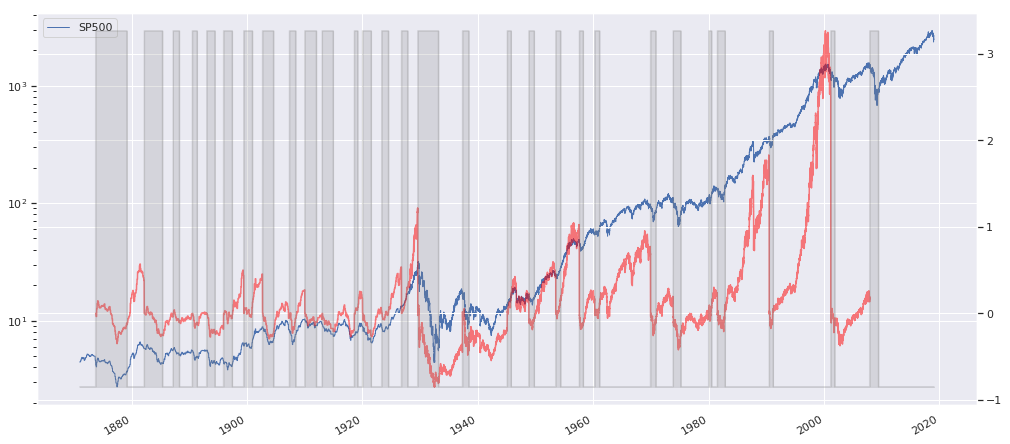

In [136]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
ax2 = ax0.twinx()
main_df['1854-12-01':].plot(kind='line',y=['SP500'],ax=ax0,linewidth=1.0,figsize=(15,8),logy=True)
main_df['SP500_chg_from_peak'].plot(kind='line', secondary_y=True, ax=ax1, alpha=.5, color='red')
main_df['recession'].plot(kind='area', secondary_y=True, ax=ax2, alpha=.2, color='grey')
#ax2.yaxis.set_visible(False)
plt.axis('off')

In [22]:
#Review our final dataframe before we move on
main_df.tail(10)

,daynum,SP500,VIXCLS,UMCSENT,STLFSI,NPPTTL_REAL,PERMIT,DGORDER,JTSQUR,T10Y2Y,T10Y3M,HOHWMN02USM065S,RETAILSMSA_REAL,UNGAP,CAPE,econuncert_h1,econuncert_h3,econuncert_h12,finuncert_h1,finuncert_h3,finuncert_h12,next_recession_date,recession,recession_start,recession_end,recession_3M,recession_6M,days_to_rec,months_to_rec,months_to_rec_round
2019-01-09,54064,2584.96,19.98,97.5,-0.667,127707.179,1328.0,250827.0,2.3,0.18,0.29,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
2019-01-10,54065,2596.64,19.50,97.5,-0.667,127707.179,1328.0,250827.0,2.3,0.18,0.31,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
2019-01-11,54066,2596.26,18.19,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.16,0.28,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
2019-01-12,54067,2596.26,18.19,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.16,0.28,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
2019-01-13,54068,2596.26,18.19,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.16,0.28,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
2019-01-14,54069,2582.61,19.07,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.18,0.26,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
2019-01-15,54070,2610.30,18.60,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.19,0.27,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
2019-01-16,54071,2616.10,19.04,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.18,0.30,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
2019-01-17,54072,2635.96,18.06,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.19,0.33,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
2019-01-18,54073,2670.71,18.06,97.5,-0.841,127707.179,1328.0,250827.0,2.3,0.19,0.33,41.9,448546.551073,-0.71,32.858812,0.626525,0.761862,0.898404,0.745267,0.813024,0.928323,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN


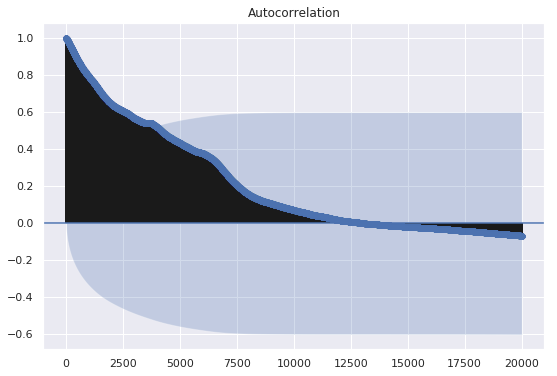

In [54]:
#Now we check for autocorrelation and decompose our target time series
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
#print(acf(main_df.SP500.dropna(), nlags=12500))
plot_acf(main_df.SP500, lags=20000)
plt.show()

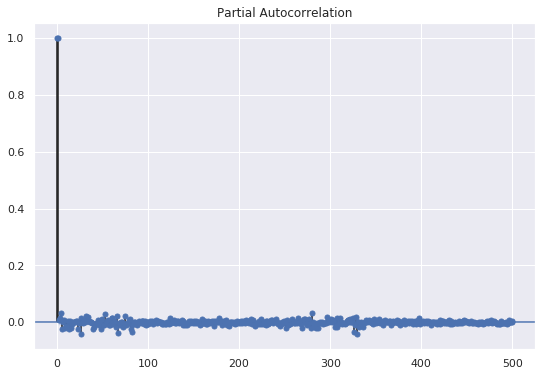

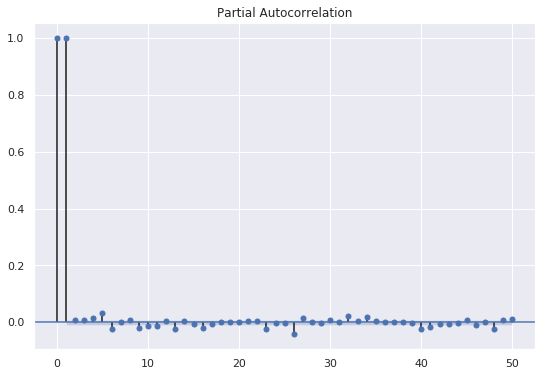

In [53]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
#print(pacf(main_df.SP500.dropna(), nlags=100))
plot_pacf(main_df.SP500, lags=500)
plot_pacf(main_df.SP500, lags=50)
plt.show()
#There does not appear to be seasonality with PACF

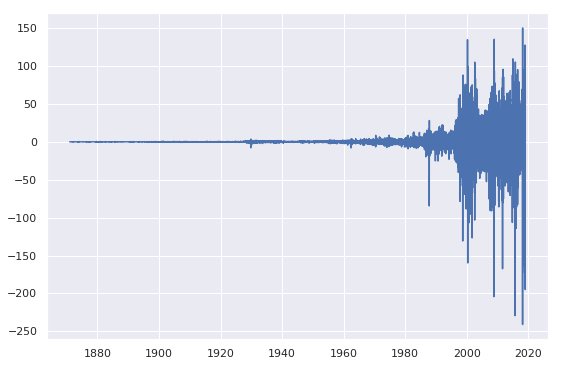

In [25]:
#differencing - not applied to the final series
diff = main_df.SP500.diff(periods = 7)
plt.plot(diff)

<Figure size 576x432 with 0 Axes>

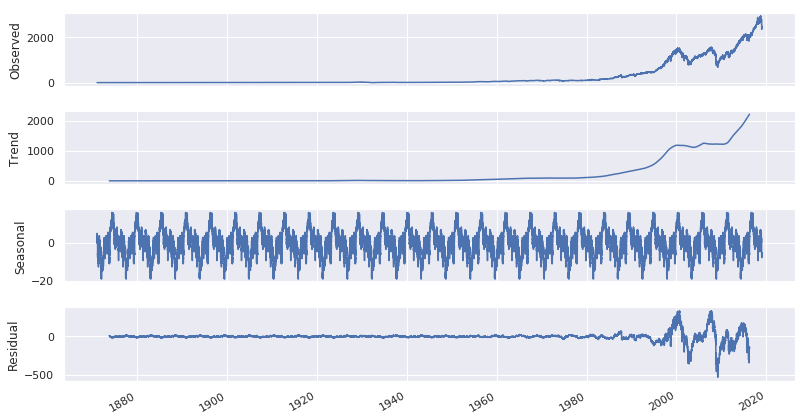

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(main_df.SP500, freq=2000)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)

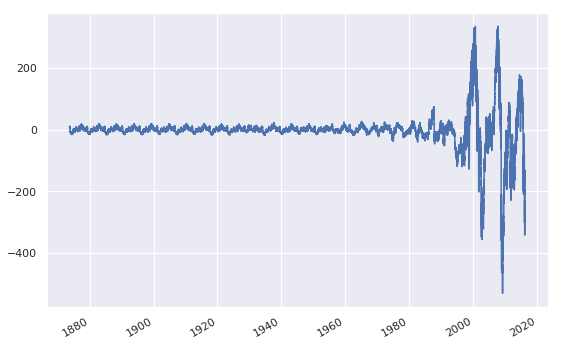

In [56]:
resid = decomposition.resid
resid.plot()

[ 1.          0.99683029  0.99398936 ... -0.00223706 -0.00226655
 -0.00230162]


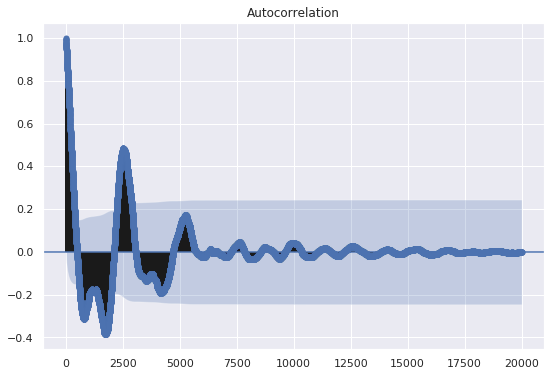

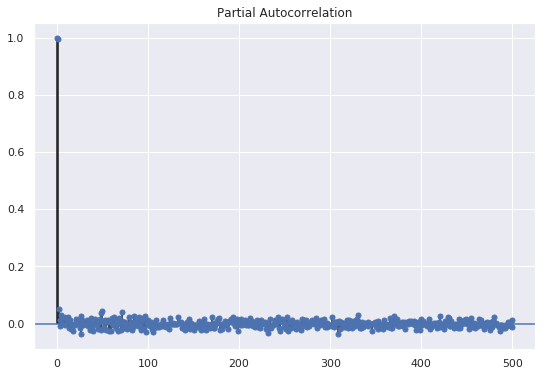

In [60]:
plot_acf(resid.dropna(), lags=20000)
plot_pacf(resid.dropna(), lags=500)
plt.show()

# Facebook Prophet

In [449]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

#format dataframe for Prophet
fb_df = main_df[['SP500']].copy()
fb_df['ds'] = fb_df.index
fb_df.rename(columns={'SP500':'y'},inplace=True)

#split train/test
fb_train = fb_df[:'1995'].copy()
fb_test = fb_df['1996':].copy()

display(fb_df.head())
display(fb_df.tail())

,y,ds
1871-01-01,4.44,1871-01-01
1871-01-02,4.44,1871-01-02
1871-01-03,4.44,1871-01-03
1871-01-04,4.44,1871-01-04
1871-01-05,4.44,1871-01-05


,y,ds
2018-12-31,2506.85,2018-12-31
2019-01-01,2508.44,2019-01-01
2019-01-02,2510.03,2019-01-02
2019-01-03,2447.89,2019-01-03
2019-01-04,2531.94,2019-01-04


In [451]:
#Instantiate the Prophet model, set our changepoints manually to known prior recession peaks
m = Prophet(changepoint_range=0.9,changepoints=rcs_df[(rcs_df.peak>=fb_train.index.min()) & (rcs_df.peak<=fb_train.index.max())].peak.values) #seasonality_mode='multiplicative',

#Fit Prophet Time Series Model
m.fit(fb_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [452]:
#future = m.make_future_dataframe(periods=365*2)
#future.tail()
future = fb_test.copy()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8401,2018-12-31,1416.598968,1296.514962,1517.696913
8402,2019-01-01,1416.695942,1297.941691,1519.849319
8403,2019-01-02,1416.820632,1300.529669,1515.794111
8404,2019-01-03,1416.907328,1300.255411,1523.258255
8405,2019-01-04,1417.000914,1297.778566,1520.946631


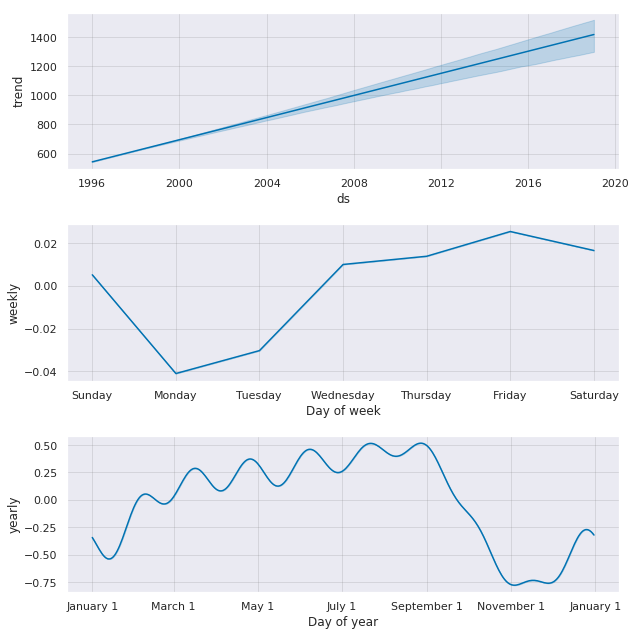

In [453]:
fig2 = m.plot_components(forecast)

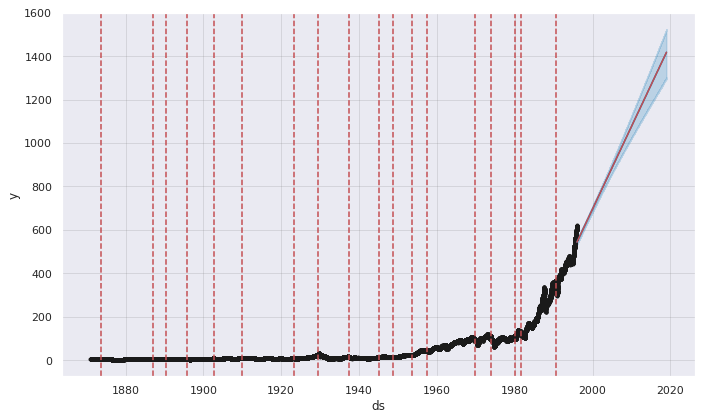

In [454]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

RMSE: 557.5473126919178
0.39396861913313136


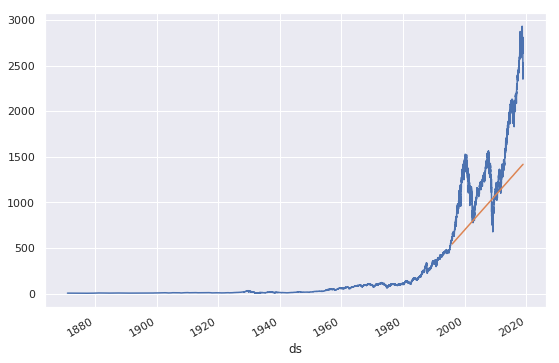

In [464]:
#Plot actuals vs. forecast
forecast_plt = forecast.set_index('ds').copy()
forecast_plt
ax = fb_df.y.plot()
forecast_plt.yhat.plot(ax=ax)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(fb_test.y, forecast_plt.yhat))
print('RMSE: {}'.format(rmse))
print(rmse/fb_test.y.mean())

In [132]:
#Cross Validation works by fitting the model on the initial period (1871 -> 1995) (18 recessions), and for every period of (1 year), making forecasts with horizon (2 years) and measuring error versus actual data
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='{} days'.format(365*(1995-1871)), period='365 days', horizon = '{} days'.format(365*2))

INFO:fbprophet:Making 23 forecasts with cutoffs between 1995-01-03 00:00:00 and 2016-12-28 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1995-01-04,489.666090,479.371965,500.373513,460.71,1995-01-03
1,1995-01-05,489.777618,478.414399,499.600836,460.34,1995-01-03
2,1995-01-06,489.895356,479.694864,499.278351,460.68,1995-01-03
3,1995-01-07,489.995536,479.007491,500.181172,460.68,1995-01-03
4,1995-01-08,490.092104,479.154608,500.223432,460.68,1995-01-03


In [158]:
display(df_cv.head())
display(df_cv.tail())
#display(df_cv[(df_cv.ds >= '2007-10')].groupby(df_cv.cutoff).count())
#df_cv[(df_cv.ds >= '2007-10') &(df_cv.cutoff == '2006-12-31')]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1995-01-04,489.666090,479.371965,500.373513,460.71,1995-01-03
1,1995-01-05,489.777618,478.414399,499.600836,460.34,1995-01-03
2,1995-01-06,489.895356,479.694864,499.278351,460.68,1995-01-03
3,1995-01-07,489.995536,479.007491,500.181172,460.68,1995-01-03
4,1995-01-08,490.092104,479.154608,500.223432,460.68,1995-01-03


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
16786,2018-12-24,2284.528864,2181.041151,2394.533187,2351.10,2016-12-28
16787,2018-12-25,2284.930147,2176.740375,2379.870414,2409.40,2016-12-28
16788,2018-12-26,2285.309885,2181.734564,2391.733002,2467.70,2016-12-28
16789,2018-12-27,2285.639474,2177.995289,2385.491462,2488.83,2016-12-28
16790,2018-12-28,2285.931376,2177.393734,2388.070857,2485.74,2016-12-28


In [133]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
3722,73 days,53503.697847,231.308664,199.648014,0.160042,0.18106
2993,74 days,53572.030748,231.456326,199.833242,0.160160,0.18106
2263,74 days,53616.002724,231.551296,199.941007,0.160232,0.18106
14673,74 days,53667.174838,231.661768,200.049467,0.160285,0.18106
8833,74 days,53676.676686,231.682275,200.071049,0.160264,0.18106


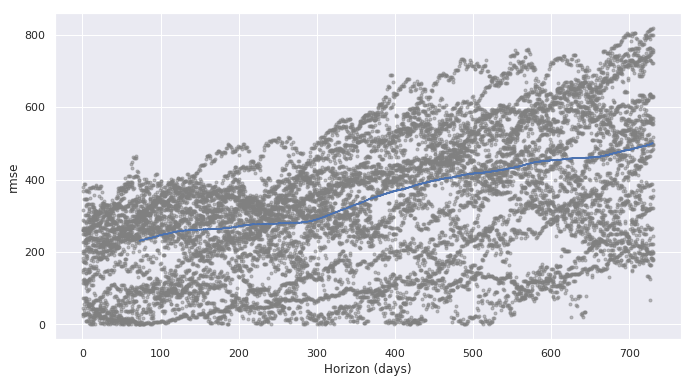

In [171]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse', rolling_window=.1)
#Its hard to interpret RMSE values but the trend line shows forecasts further out become worse

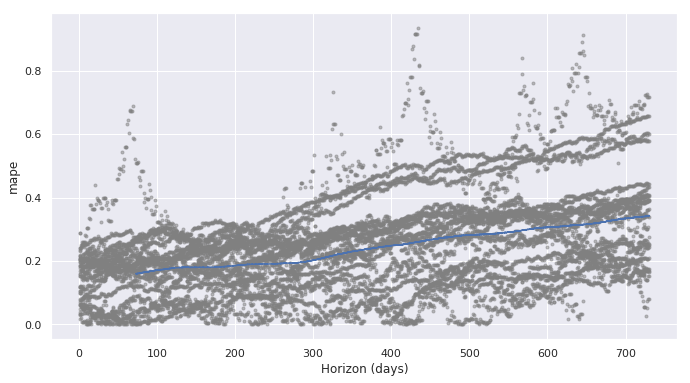

In [173]:
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=.1)
#using MAPE makes it more clear that the model is not doing well around the recessions
#Mean Absolute Percent Error

In [ ]:
#Get average RMSE for CV data

## Prophet with additional regressors
The extra regressor must be known for both the history and for future dates. It thus must either be something that has known future values (such as nfl_sunday), or something that has separately been forecasted elsewhere. Prophet will also raise an error if the regressor is constant throughout the history, since there is nothing to fit from it.

Extra regressors are put in the linear component of the model, so the underlying model is that the time series depends on the extra regressor as either an additive or multiplicative factor.

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors

In [419]:
#We are not going to be able to predict the trend using the trend - we need to use outside predictors (hopefully leading)

#Need to remove all NaN - this is an issue for older time periods missing data
#100% complete data 
#main_df[~main_df.isnull().any(axis=1)].loc['2003-01-01':]

#oldest data for main predictors (VIX starts on 1990-01-02)
fb_df2 = main_df.loc['1990-01-02':][['SP500','CAPE','UNGAP','UMCSENT','PERMIT','HOHWMN02USM065S','econuncert_h12','finuncert_h12','T10Y2Y','T10Y3M','VIXCLS']].copy()

#format dataframe for Prophet
fb_df2['ds'] = fb_df2.index
fb_df2.rename(columns={'SP500':'y'},inplace=True)
fb_df2.head()

#Because we are using additional regressors we need them to be present in our future dataframe
#which means we must split our dataframe into train/test
fb_df2_train = fb_df2.loc[:'2001-10-31'].copy()
fb_df2_test = fb_df2.loc['2001-11-01':].copy() #trough of 2001 recession

m2 = Prophet(changepoint_range=0.9,changepoints=rcs_df[(rcs_df.peak>=fb_df2_train.index.min()) & (rcs_df.peak<=fb_df2_train.index.max())].peak.values)
m2.add_regressor('CAPE')
m2.add_regressor('UNGAP')
m2.add_regressor('UMCSENT')
m2.add_regressor('PERMIT')
m2.add_regressor('HOHWMN02USM065S')
m2.add_regressor('econuncert_h12')
m2.add_regressor('finuncert_h12')
m2.add_regressor('T10Y2Y')
m2.add_regressor('T10Y3M')
m2.add_regressor('VIXCLS')

#Fit Prophet TS Model
m2.fit(fb_df2_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [458]:
#future = m2.make_future_dataframe(periods=365*2)
#future.tail()
future = fb_df2_test.copy()
fb_df2_test.tail()
forecast2 = m2.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6270,2018-12-31,750.425037,-2768.431256,4837.552517
6271,2019-01-01,753.462345,-2771.475727,4826.421873
6272,2019-01-02,755.968698,-2761.646054,4866.976761
6273,2019-01-03,748.019151,-2770.357838,4865.391421
6274,2019-01-04,762.249939,-2745.515494,4865.687357


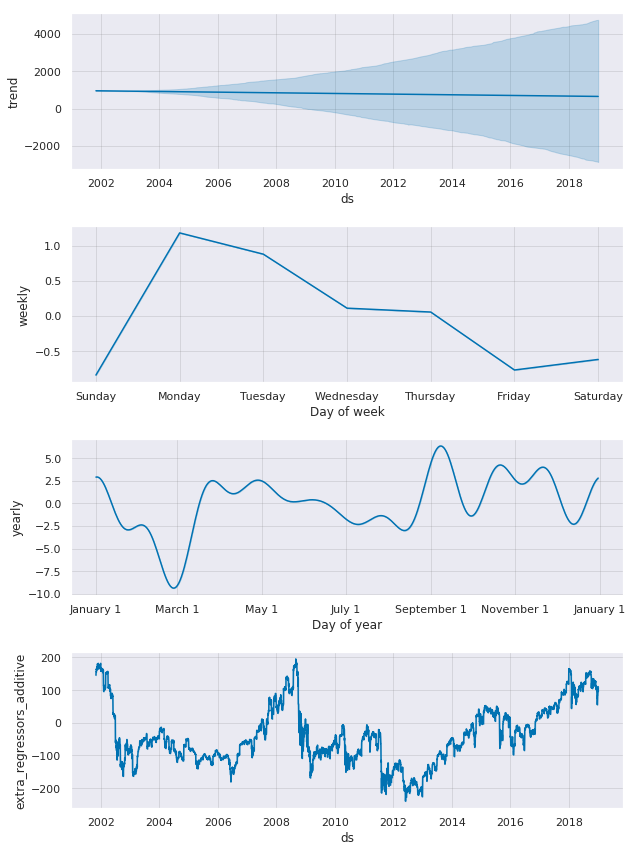

In [459]:
fig2 = m2.plot_components(forecast2)

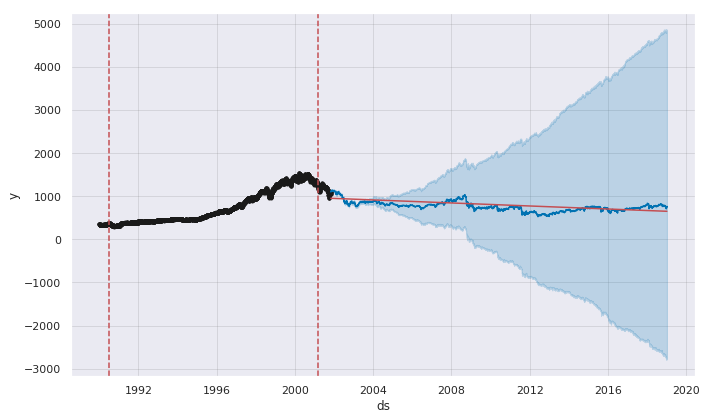

In [460]:
from fbprophet.plot import add_changepoints_to_plot
fig = m2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m2, forecast2)

RMSE: 951.6251161806773
0.6243823930244524


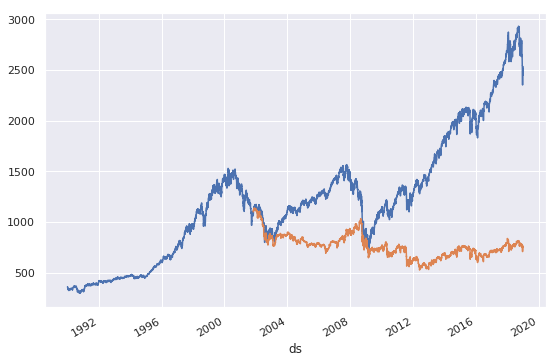

In [465]:
#Plot actuals vs. forecast
forecast_plt = forecast2.set_index('ds').copy()
forecast_plt
ax = fb_df2.y.plot()
forecast_plt.yhat.plot(ax=ax)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(fb_df2_test.y, forecast_plt.yhat))
print('RMSE: {}'.format(rmse))
print(rmse/fb_df2_test.y.mean())

RMSE: 1090.5930508566041
0.715562344174614


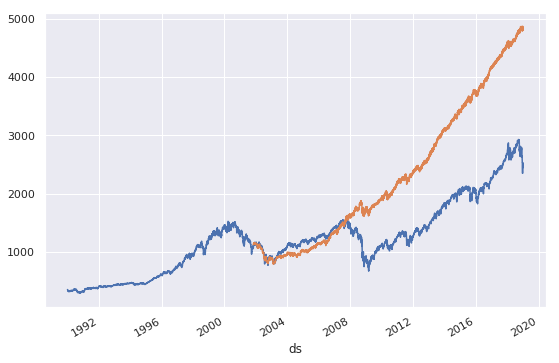

In [466]:
#Plot actuals vs. UPPER forecast
forecast_plt = forecast2.set_index('ds').copy()
forecast_plt
ax = fb_df2.y.plot()
forecast_plt.yhat_upper.plot(ax=ax)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(fb_df2_test.y, forecast_plt.yhat_upper))
print('RMSE: {}'.format(rmse))
print(rmse/fb_df2_test.y.mean())

In [427]:
#Cross Validation
m3 = Prophet(changepoint_range=0.9,changepoints=rcs_df[(rcs_df.peak>=fb_df2.index.min()) & (rcs_df.peak<=fb_df2.index.max())].peak.values)
m3.add_regressor('CAPE')
m3.add_regressor('UNGAP')
m3.add_regressor('UMCSENT')
m3.add_regressor('PERMIT')
m3.add_regressor('HOHWMN02USM065S')
m3.add_regressor('econuncert_h12')
m3.add_regressor('finuncert_h12')
m3.add_regressor('T10Y2Y')
m3.add_regressor('T10Y3M')
m3.add_regressor('VIXCLS')
m3.fit(fb_df2)
df_cv2 = cross_validation(m3, initial='{} days'.format(365*(2001-1990)), period='180 days', horizon = '{} days'.format(180))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 36 forecasts with cutoffs between 2001-04-08 00:00:00 and 2018-07-08 00:00:00


,horizon,mse,rmse,mae,mape,coverage
2519,180 days,17000.984008,130.387822,93.134568,0.069226,0.300926
5579,180 days,16996.783270,130.371712,93.074877,0.069172,0.302469
2699,180 days,17123.184802,130.855588,93.332949,0.069352,0.302469
1079,180 days,17062.053396,130.621795,93.153914,0.069252,0.302469
6480,180 days,17079.856356,130.689924,93.252339,0.069258,0.302469


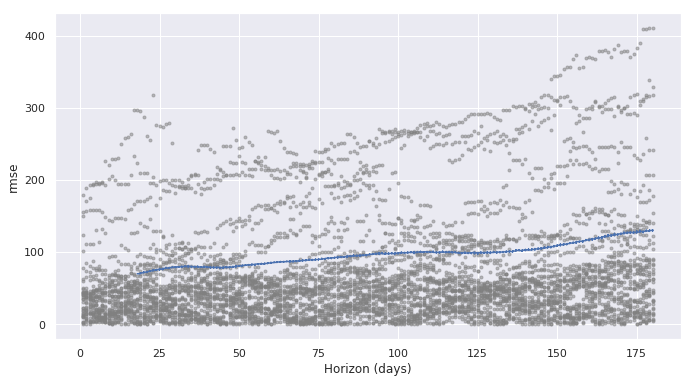

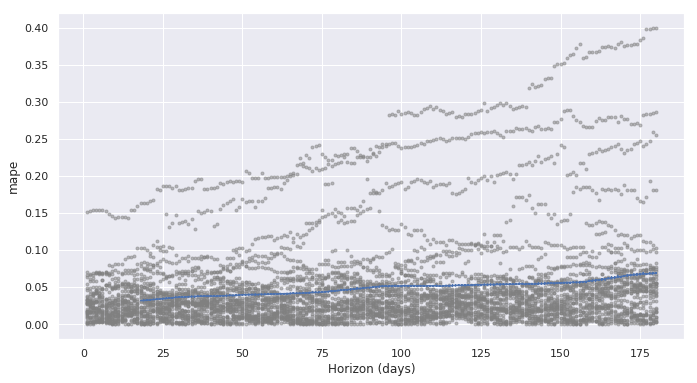

In [428]:
df_p2 = performance_metrics(df_cv2)
display(df_p2.tail())
fig1 = plot_cross_validation_metric(df_cv2, metric='rmse', rolling_window=.1)
fig2 = plot_cross_validation_metric(df_cv2, metric='mape', rolling_window=.1)

## Some other things to try:
1. Add series leads/lags (create leading indicators)
2. Add trended attributes (max value of f over past m months)
3. Tune hyperparamters
4. Reduce granularity to monthly data https://facebook.github.io/prophet/docs/non-daily_data.html#monthly-data
5. Point in time logistic model (3mo ahead, 6mo ahead)

In [26]:
#Additional predictors here:
#https://cdn.titanvest.com/library/Titan_State_of_Markets.pdf
#Stock buyback activity, stock earnings growth, level of corp profits, 
#Leading indicators, such as growth in industrial transports, remain healthy
# P/E multiples vs. interest rates and inflation

#Manufacturers Index 
#https://www.instituteforsupplymanagement.org/ismreport/mfgrob.cfm?SSO=1&smid=nytcore-ios-share

#Google search trends data focused on specific phrases could be predictive 
#https://github.com/GeneralMills/pytrends


"""
Subtracting the natural rate of interest—which is the neutral fed funds rate, neither contractionary nor stimulative for the economy—from the real fed funds rate gives us a gauge of how loose or tight Fed policy is. 
Leading up to past recessions, the Fed has usually hiked rates beyond the natural rate to cool the labor market and get ahead of inflation, only to inadvertently push the economy into recession. 
Looking at the current cycle, we expect quarterly rate hikes to resume in December. This will put Fed policy well into restrictive territory next year, barring a sharper increase in the natural rate than we expect.
*Natural rate is Laubach-Williams one-sided filtered estimate.
Real Fed Funds Rate – Natural Rate of Interest (r*)

https://www.frbsf.org/economic-research/files/el2017-16.pdf
Starting with a view of longer-run trends, Figure 1 plots the inflation-adjusted or “real” federal funds rate,
computed as the nominal federal funds rate minus the trailing four-quarter core personal consumption
expenditures (PCE) inflation rate. Core inflation tends to be a better predictor of future inflation because it
removes the volatile food and energy components. 

Might be able to use Potential GDP Growth as a stand-in for proper Laubach-Williams r* model

data = fred.get_series('DFF') # Effective Federal Funds Rate, Daily
print(data.tail())

#use PCE to adjust for inflation
data = fred.get_series('PCEPILFE') # Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index), Monthly
print(data.tail())

#May need for calculation of r*
data = fred.get_series('GDPPOT') # Real Potential Gross Domestic Product, Quarterly
print(data.tail())

"""



"""NOTES:

Paul Comments: 
There is some work on this already (check Philly Fed and St louis Fed working papers).  I looked at these recently, highlighted the most important in red. I personally feel it is in the following order:
1.  10-2 yr spread (60%)
2.  S&P500 vs recent(last 12 or 24mo) peak/high (20%)    
3.  Change in Housing permits (10%)
4.  Change in Manufacturing Orders (5%)
5.  Consumer Sentiment (5%)

•   Manufacturing survey….leading indicator. Given lead times to build, this is historically a leading indicator. It was more pronounce when we were more of a manufacturing based society with less global influence but still predictive.
•   Housing Permits….. leading indicator given lead time to build. Also note interest rate increases slow consumer demand and construction companies know this. Somewhat correlated to yield curve.
•   Consumer sentiment….(mich survey) …leading indicator however I feel the S&P500 is a reliable gauge for this and more real time. The two series are highly correlated.

JPMorgan's proprietary model considers the levels of several economic indicators, including consumer sentiment, manufacturing sentiment, building permits, auto sales, and unemployment.
JPMorgan notes that nonfarm payrolls is actually not part of the model. But the unemployment rate is. Interestingly, a low unemployment rate can be considered an ominous sign.

“The unemployment rate enters the model in two ways," Edgerton explained. "As a near-term indicator, we watch for increases in the unemployment rate that occur near the beginning of recessions. So this morning's move down in the unemployment rate lowered the recession probability in our near-term model. But we also find the level of the unemployment rate to be one of the most useful indicators of medium-term recession risk. So the move down in unemployment raises the model's view of the risk of economic overheating in the medium run and raises the 'background risk' of recession."

Indeed, recessions begin when things are very good. It's only when reports come in that the data has turned that we realize we've been in a recession.
https://finance.yahoo.com/news/jpmorgan-recession-risk-new-high-160251309.html

Best investments in case of an inverted yield curve
https://www.wsj.com/articles/the-best-investments-in-case-of-an-inverted-yield-curve-1536545041?emailToken=e7d3ad6442c26d159eb5bc7903c7f80603yQYaTVNumvrlRPOpnMOdMNGYlKz9R0nF7hBawD18PIgfIs2FyveE1L1m8yYL2DkzsrmGL+Gt0ehEfETb7Q1TP6do5LV1+ScyBBPIcgjOqLKKtUfjtFBaeAgRiUo7m2&reflink=article_email_share

Guggenheim Models:
https://www.guggenheiminvestments.com/perspectives/macroeconomic-research/forecasting-the-next-recession
https://www.guggenheiminvestments.com/perspectives/macroeconomic-research/updating-our-outlook-for-recession-timing
Includes cycles ending in 1970, 1980, 1990, 2001, and 2007.

Paul O. - What to do just before recession: 
Between now and 12 mos from now, bond prices will have pressure so interest rate hedge ETF could better navigate this. Then swap them out 13mos (bypass short term cap gains tax) from now for non hedge versions so you can gain from price increases associate with rate decreases.  Just need to watch out for credit risk in order:
1.  Junk
2.  Investment grade Corp
3.  Muni

Paul O. - Economist from Moody's last week said the earliest predictor of a recession is when UE falls below the natural rate of unemployment. This lead is 3yrs, it happened June-2017.

####OFFICIAL RECESSION DATES
https://www.nber.org/cycles.html

#Natural rate of interest modelling: 
https://www.frbsf.org/economic-research/files/wp2016-11.pdf
https://www.frbsf.org/economic-research/files/el2017-16.pdf

#Economic Uncertainty Index (increases sharply just before recession) (not to be confused with Economic Policy Uncertainty)
https://www.sydneyludvigson.com/data-and-appendixes/
https://www.sydneyludvigson.com/s/MacroFinanceUncertainty_2018AUG_update.zip

#Leading Economic Index (LEI)
The Conference Board Leading Economic Index (LEI), which measures 10 key variables, is itself a recession predictor, albeit a fallible one. 
It has been irreverently said that the LEI predicted 15 out of the last eight recessions. 
Nevertheless, growth in the LEI always slows on a year-over-year basis heading into a recession, and turns negative about seven months out, on average. 
Looking at the current cycle, LEI growth of 4 percent over the past year has been on par with past cycles two years before a recession, and we will be watching for a deceleration over the course of the coming year.
Leading Economic Index, Year-over-Year % Change

https://www.conference-board.org/data/datasearch.cfm?cid=1&output=2&sector=BCI-01A%20-%20Composite%20Indexes-Leading%20Economic%20Indicators
#Could scrape the index from their public releases:
https://www.conference-board.org/data/bcicountry.cfm?cid=1

###USE FACEBOOK PROPHET FOR TIME SERIES MODEL
http://www.degeneratestate.org/posts/2017/Jul/24/making-a-prophet/
https://facebook.github.io/prophet/docs/quick_start.html#python-api
https://peerj.com/preprints/3190.pdf

##Ray Dalio on timing the market
https://www.youtube.com/watch?v=5C43i3yclec

"""

'NOTES:\n\nPaul Comments: \nThere is some work on this already (check Philly Fed and St louis Fed working papers).  I looked at these recently, highlighted the most important in red. I personally feel it is in the following order:\n1.  10-2 yr spread (60%)\n2.  S&P500 vs recent(last 12 or 24mo) peak/high (20%)    \n3.  Change in Housing permits (10%)\n4.  Change in Manufacturing Orders (5%)\n5.  Consumer Sentiment (5%)\n\n•   Manufacturing survey….leading indicator. Given lead times to build, this is historically a leading indicator. It was more pronounce when we were more of a manufacturing based society with less global influence but still predictive.\n•   Housing Permits….. leading indicator given lead time to build. Also note interest rate increases slow consumer demand and construction companies know this. Somewhat correlated to yield curve.\n•   Consumer sentiment….(mich survey) …leading indicator however I feel the S&P500 is a reliable gauge for this and more real time. The two 